In [1]:
import numpy as np

from data_loader import load_txt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid

from metrics import get_performance_measure, print_metric_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def my_cross_val_score(clf, X_train, y_train, cv):
    # print('here')
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    accs = [] 
    precs = [] 
    recs = [] 
    f1s = [] 
    rocs = []
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        clf.fit(X_train_fold, y_train_fold)  
        y_pred = clf.predict(X_val_fold)  
        y_pred_proba = clf.predict_proba(X_val_fold)

        accuracy, precison, recall, f1, roc = get_performance_measure(y_val_fold, y_pred, y_pred_proba[:, 1])
        # print(f1)

        accs.append(accuracy)
        precs.append(precison)
        recs.append(recall)
        f1s.append(f1)
        rocs.append(roc)

    return clf, accs, precs, recs, f1s, rocs

### Hyper-parameter Tuning

In [4]:
k = 10

X_train, X_test, y_train, y_test = load_txt(2) 
parameters = {'max_depth':[7,10,15],
              'n_estimators': [100, 200, 300, 1000]}

grid = ParameterGrid(parameters)

best_acc = -999999
best_prec = -999999
best_rec = -999999
best_f1 = -999999
best_roc = -999999
best_params = {}
best_clf = 0

counter = 1
for params in grid:
  print(str(counter) + '  ', end="")
  if counter % 32 == 0:
    print()
  counter = counter + 1

  # clf = SVC(kernel=params['kernel'], C=params['C'], gamma=params['gamma'], probability=True)
  clf = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'], random_state=0)

  clf, accs, precs, recs, f1s, rocs = my_cross_val_score(clf, X_train, y_train, cv=k)
  # print("Accuracys for each fold:", accs)
  # print("Average accuracy (val):", np.array(accs).mean())
  # print('------------------------')

  # print("Rocs for each fold:", rocs)
  # print("Average roc score (val):", np.array(rocs).mean())

  clf.fit(X_train, y_train)  # Train the model on the entire training data
  y_train_pred = clf.predict(X_train)  # Predict on the test data
  y_train_pred_proba = clf.predict_proba(X_train)

  acc, prec, rec, f1, roc = get_performance_measure(y_train, y_train_pred, y_train_pred_proba[:, 1])

  if acc > best_acc:
    best_acc = acc
    best_prec = prec
    best_rec = rec
    best_f1 = f1
    best_roc = roc

    best_params = params
    best_clf = clf

print()

y_train_pred = best_clf.predict(X_train)  # Predict on the test data
y_train_pred_proba = clf.predict_proba(X_train)
train_acc, train_prec, train_rec, train_f1, train_roc = get_performance_measure(y_train, y_train_pred, y_train_pred_proba[:, 1])

y_test_pred = best_clf.predict(X_test)  # Predict on the test data
y_test_pred_proba = clf.predict_proba(X_test)
test_acc, test_prec, test_rec, test_f1, test_roc = get_performance_measure(y_test, y_test_pred, y_test_pred_proba[:, 1])

print('best parameters:', best_params)
print('train accuracy:', train_acc)
print('train precision:', train_prec)
print('train recall:', train_rec)
print('train f1 score:', train_f1)
print('train auroc score:', train_roc)
print('------------------------')
print('test accuracy:', test_acc)
print('test precision:', test_prec)
print('test recall:', test_rec)
print('test f1 score:', test_f1)
print('test auroc score:', test_roc)

dataset 2
1  2  3  4  5  6  7  8  9  10  11  12  
best parameters: {'max_depth': 10, 'n_estimators': 100}
train accuracy: 1.0
train precision: 1.0
train recall: 1.0
train f1 score: 1.0
train auroc score: 1.0
------------------------
test accuracy: 0.6666666666666666
test precision: 0.41935483870967744
test recall: 0.5
test f1 score: 0.45614035087719296
test auroc score: 0.7675086107921929


### bias-variance analysis

#### Effect of number of trees

dataset 1
1  Parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(n_estimators=10, random_state=0)>
test accuracy 0.956140350877193

2  Parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(n_estimators=20, random_state=0)>
test accuracy 0.9736842105263158

3  Parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(n_estimators=50, random_state=0)>
test accuracy 0.9649122807017544

4  Parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(random_state=0)>
test accuracy 0.9649122807017544

5  Parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(n_estimators=200, random_state=0)>
test accuracy 0.9649122807017544

6  Parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(n_estimators=300, random_state=0)>
test accuracy 0.9649122807017544

7  Parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(n_estimators=1000, random_state=0)>
te

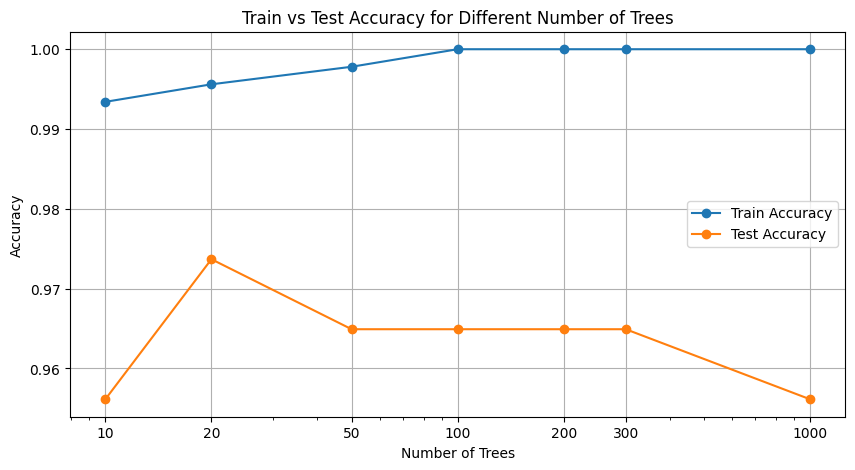

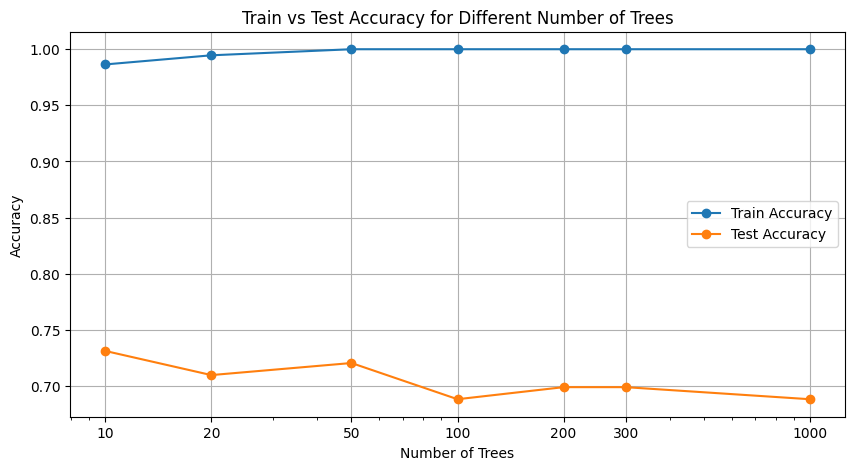

In [6]:
k = 10

def check_num_of_trees_effect(dataset_no):
    X_train, X_test, y_train, y_test = load_txt(dataset_no) 
    tree_list = [10, 20, 50, 100, 200, 300, 1000]
    parameters = {'n_estimators':tree_list}

    grid = ParameterGrid(parameters)
    train_accs = []
    test_accs = []

    counter = 1
    for params in grid:
        print(str(counter) + '  ', end="")
        if counter % 32 == 0:
            print()
        counter = counter + 1
        # if counter == 3:
        #   break
        # print(type(params))
        # print(params)
        clf = RandomForestClassifier(n_estimators=params['n_estimators'], random_state=0)
        accs = cross_val_score(clf, X_train, y_train, cv=k, scoring='accuracy')

        clf.fit(X_train, y_train)
        
        y_pred_train = clf.predict(X_train)
        train_acc = accuracy_score(y_train, y_pred_train)
        train_accs.append(train_acc)

        y_pred_test = clf.predict(X_test)
        test_acc = accuracy_score(y_test, y_pred_test)
        print('Parameters:',clf.get_params,end='\n')
        print('test accuracy', test_acc)
        test_accs.append(test_acc)
        print()

    plt.figure(figsize=(10, 5))
    plt.plot(tree_list, train_accs, label='Train Accuracy', marker='o')
    plt.plot(tree_list, test_accs, label='Test Accuracy', marker='o')

    # Setting the logarithmic scale for x-axis
    plt.xscale('log')

    # Adding titles and labels
    plt.title('Train vs Test Accuracy for Different Number of Trees')
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(ticks=tree_list, labels=tree_list)
    plt.legend()

    img_filename = '/u/epw9kz/academic/first_year/ML/project/notebooks/plots/rf_tree_num_data' + str(dataset_no) + '.png'
    print(img_filename)
    plt.savefig(img_filename, dpi=300, bbox_inches='tight')  # Saves the plot as a PNG file
    # plt.show()

dataset_no = 1
check_num_of_trees_effect(dataset_no)

dataset_no = 2 
check_num_of_trees_effect(dataset_no)
print('done!')

dataset 1
1  Parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=1, random_state=0)>
test accuracy 0.9210526315789473

2  Parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=4, random_state=0)>
test accuracy 0.956140350877193

3  Parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=7, random_state=0)>
test accuracy 0.9473684210526315

4  Parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=10, random_state=0)>
test accuracy 0.9649122807017544

5  Parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=15, random_state=0)>
test accuracy 0.9649122807017544

6  Parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=50, random_state=0)>
test accuracy 0.9649122807017544

/u/epw9kz/academic/first_year/ML/project/notebooks/plots/rf_depth_data1.png
dataset 2
1  Parameters: <bound method BaseEstim

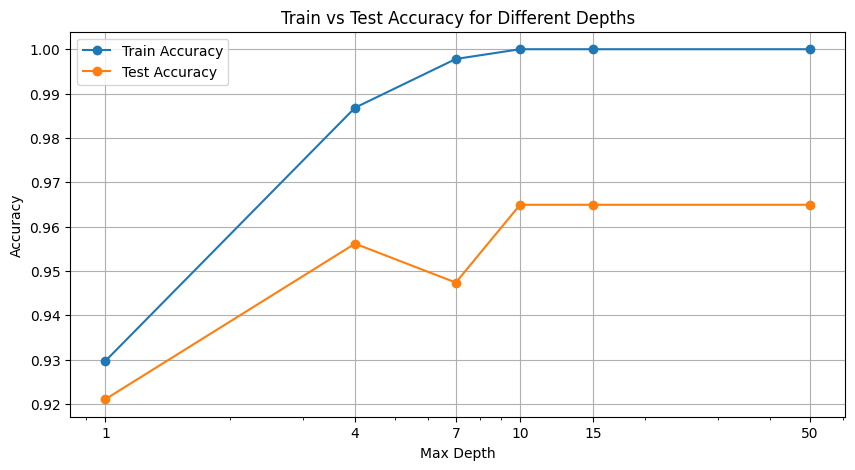

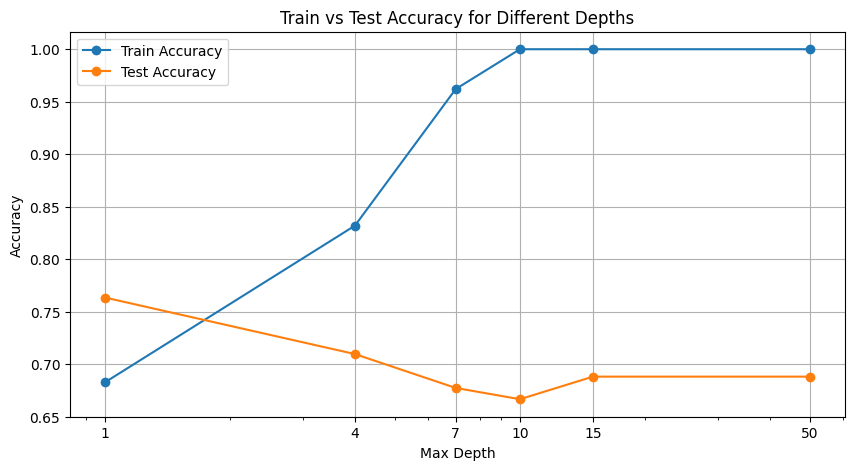

In [8]:
def check_depth_effect(dataset_no):
    X_train, X_test, y_train, y_test = load_txt(dataset_no) 
    depth_list = [1, 4, 7,10,15, 50]
    parameters = {'max_depth':depth_list}

    grid = ParameterGrid(parameters)
    train_accs = []
    test_accs = []

    counter = 1
    for params in grid:
        print(str(counter) + '  ', end="")
        if counter % 32 == 0:
            print()
        counter = counter + 1
        # if counter == 3:
        #   break
        # print(type(params))
        # print(params)
        clf = RandomForestClassifier(max_depth=params['max_depth'], random_state=0)

        accs = cross_val_score(clf, X_train, y_train, cv=k, scoring='accuracy')

        clf.fit(X_train, y_train)
        
        y_pred_train = clf.predict(X_train)
        train_acc = accuracy_score(y_train, y_pred_train)
        train_accs.append(train_acc)

        y_pred_test = clf.predict(X_test)
        test_acc = accuracy_score(y_test, y_pred_test)
        print('Parameters:',clf.get_params,end='\n')
        print('test accuracy', test_acc)
        test_accs.append(test_acc)
        print()

    plt.figure(figsize=(10, 5))
    plt.plot(depth_list, train_accs, label='Train Accuracy', marker='o')
    plt.plot(depth_list, test_accs, label='Test Accuracy', marker='o')

    # Setting the logarithmic scale for x-axis
    plt.xscale('log')

    # Adding titles and labels
    plt.title('Train vs Test Accuracy for Different Depths')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(ticks=depth_list, labels=depth_list)
    plt.legend()

    img_filename = '/u/epw9kz/academic/first_year/ML/project/notebooks/plots/rf_depth_data' + str(dataset_no) + '.png'
    print(img_filename)
    plt.savefig(img_filename, dpi=300, bbox_inches='tight')  # Saves the plot as a PNG file
    # plt.show()

dataset_no = 1
check_depth_effect(dataset_no)

dataset_no = 2 
check_depth_effect(dataset_no)
print('done!')